In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision 
from torchvision import transforms, datasets, models
import os
import numpy as np

In [15]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean and std of each channel
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), # use validation as test set
}

In [16]:
#Download the dataset first  -> https://download.pytorch.org/tutorial/hymenoptera_data.zip
data_dir = 'hymenoptera_data'

#Create a dictionary that contains the information of the image in both the training and validation set
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}

#Create a dictionary that contains the data loader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True, 
                                              num_workers=4) for x in ['train', 'val']}

#Create a dictionary that contains the size of each dataset (train validation)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#Get a class name
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
model_conv = torchvision.models.resnet18(pretrained = True)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
#Freeze all alyers in the network
for param in model_conv.parameters():
    param.requires_grad = False #stop the back propaation

In [19]:
#Get the number of inputs in the last layer
num_ftrs = model_conv.fc.in_features
#Reconstruct the last layer
model_conv.fc = nn.Linear(num_ftrs,2)

In [20]:
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

In [21]:
#Understand what's happening
from torch.autograd import Variable
iteration = 0
correct = 0
for inputs,labels in dataloaders['train']:
    if iteration == 1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For some iteration, this is what happening:")
    print("Input shape:", inputs.shape)  # torch.Size([4, 3, 224, 224]) - > batch_size, RGB image, transformation 224*224
    print("Outputs shape:", labels.shape)
    print("Labels are {}".format(labels))
    output = model_conv(inputs)
    print("Output Tensor:", output)
    print("Output Shape", output.shape)
    _, predicted = torch.max(output,1)
    print("Predicted:", predicted)
    print("Predicted shape", predicted.shape)
    correct += (predicted == labels).sum()
    print("Correct Predictions:",correct)

    iteration +=1


For some iteration, this is what happening:
Input shape: torch.Size([4, 3, 224, 224])
Outputs shape: torch.Size([4])
Labels are tensor([0, 0, 0, 1])
Output Tensor: tensor([[-0.1199, -0.9007],
        [-0.6117, -1.0757],
        [-0.0828, -2.1218],
        [-0.7265, -2.3357]], grad_fn=<AddmmBackward0>)
Output Shape torch.Size([4, 2])
Predicted: tensor([0, 0, 0, 0])
Predicted shape torch.Size([4])
Correct Predictions: tensor(3)


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9) #We only optimize the parameters of fully connected layer model_conv.fc!!
#Decay the lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.1)

In [23]:
#This is to demostrate what happens in the background of scheduler.step()
#No need to run this cell unless you want to create your own scheduler
# def lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
#     """Decay the lr by a factor of 0.1 every lr_decay_epochs"""
#     lr = init_lr * (0.1 **(epoch // lr_decay_epoch))

#     if epoch % lr_decay_epoch == 0:
#         print("LR is set to {}". format(lr))

#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr

#     return optimizer

In [24]:
num_epochs = 25
for epoch in range (num_epochs):
    exp_lr_scheduler.step()
    #Reset the correct to 0 after passing though the entire dataset
    correct = 0
    for images, labels in dataloaders['train']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()
        outputs = model_conv(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs,1)
        correct += (predicted == labels).sum()
    
    train_acc = 100 * correct / dataset_sizes['train']
    print("Epoch {}/{}, Loss: {:.3f}, Train Accuracy: {:.3f}".format(epoch+1, num_epochs, loss.data, train_acc))

/opt/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/25, Loss: 0.256, Train Accuracy: 64.754
Epoch 2/25, Loss: 0.115, Train Accuracy: 80.738
Epoch 3/25, Loss: 0.277, Train Accuracy: 79.098
Epoch 4/25, Loss: 0.050, Train Accuracy: 74.180
Epoch 5/25, Loss: 0.175, Train Accuracy: 73.770
Epoch 6/25, Loss: 0.386, Train Accuracy: 82.377
Epoch 7/25, Loss: 0.247, Train Accuracy: 82.377
Epoch 8/25, Loss: 0.163, Train Accuracy: 82.787
Epoch 9/25, Loss: 0.066, Train Accuracy: 82.787
Epoch 10/25, Loss: 0.119, Train Accuracy: 81.557
Epoch 11/25, Loss: 1.588, Train Accuracy: 80.328
Epoch 12/25, Loss: 0.346, Train Accuracy: 88.115
Epoch 13/25, Loss: 0.151, Train Accuracy: 84.426
Epoch 14/25, Loss: 0.149, Train Accuracy: 84.836
Epoch 15/25, Loss: 0.173, Train Accuracy: 86.475
Epoch 16/25, Loss: 0.666, Train Accuracy: 88.115
Epoch 17/25, Loss: 0.163, Train Accuracy: 83.607
Epoch 18/25, Loss: 0.018, Train Accuracy: 80.328
Epoch 19/25, Loss: 0.219, Train Accuracy: 87.705
Epoch 20/25, Loss: 0.670, Train Accuracy: 86.885
Epoch 21/25, Loss: 0.587, Tra

In [25]:
model_conv.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['val']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    print("Val Accuracy: {:.3f}".format(val_acc))

Val Accuracy: 95.425


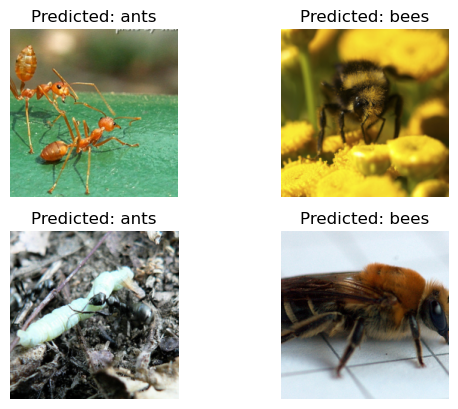

In [26]:
#Visualize some predictions
import matplotlib.pyplot as plt
fg = plt.figure()
show_bact = 0
index = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(dataloaders['val']):
        if show_bact ==1:
            break
        show_bact+=1

        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        outputs = model_conv(images)
        _, predicted = torch.max(outputs,1)

        for i in range(len(labels)):
            index += 1
            ax = fg.add_subplot(2,2,index)
            ax.axis('off')
            ax.set_title("Predicted: {}".format(class_names[predicted[i]]))
            input_img = images.cpu().data[i]
            inp = input_img.numpy().transpose((1,2,0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp,0,1)
            plt.imshow(inp)
            if index == 16:
                show_bact = 1
                break
        if show_bact:
            break